In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
%%writefile train.py
""" build and train a TFAutoModel from npz or tfrec dataset """
import os
import gc
import time
import random

import logging
import numpy as np
import pandas as pd
# from tqdm.notebook import tqdm

import tensorflow_addons as tfa
# from tensorflow_addons.optimizers.utils import fit_bn

import tensorflow as tf

from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score

from one_cycle_scheduler import OneCycleScheduler
from visual import save_fig, plot_history
from focal_loss import focal_loss

logging.getLogger('tensorflow').setLevel(logging.ERROR)


def compile_model(model,
                  optimizer='LAMB', lr=2e-5, weight_decay=1e-6,
                  loss_fn='bce', label_smoothing=0.01,
                  pos_weight=5, gamma=2.0,  ## focal loss
                  amp=False,
                  **_):
    """ compile the model with a loss function and an optimizer """
    if loss_fn == 'focal':
        loss = focal_loss(pos_weight=pos_weight, gamma=gamma, label_smoothing=label_smoothing)
    elif loss_fn == 'bce':
        loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing)

    if optimizer == 'LAMB':
        opt = tfa.optimizers.LAMB(lr=lr, weight_decay_rate=weight_decay)
    elif optimizer == 'AdamW':
        opt = tfa.optimizers.AdamW(lr=lr, weight_decay=weight_decay)
    print(opt)

    if amp:
        print('Using auto_mixed_precision.')
        tf.config.optimizer.set_jit(True)
        tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
        opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt, 'dynamic')

    model.compile(
        optimizer=opt,
        loss=loss,
        metrics=[tf.keras.metrics.AUC(name='auc')]
    )

    return model



def train_model(model, strategy, checkpoint_path, datasets,
                epochs=30, steps_per_epoch=250,
                lr=2e-5, one_cycle=True, warm_up=1,
                mom_min=0.85, mom_max=0.95,
                div_factor=100, final_div_factor=250,
                callback=None,
                **_):
    """ train the given model """
    train_dataset, valid_dataset, test_dataset = datasets

    ## Train
    callbacks = [] if callback is None else [callback]
    callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_auc', min_delta=1e-4,
                                                      mode='max', patience=epochs//5, verbose=1,
                                                      restore_best_weights=False)) # restore later

    if one_cycle:
        callbacks.append(OneCycleScheduler(lr_max=lr, steps=steps_per_epoch*epochs,
                                           mom_min=mom_min, mom_max=mom_max,
                                           phase_1_pct=warm_up/epochs,
                                           div_factor=div_factor,
                                           final_div_factor=final_div_factor))
    else:
        callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.31,
                                                              patience=2, cooldown=1, mode='max',
                                                              verbose=1, min_delta=1e-4))

    callbacks.append(tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        monitor='val_auc',
                                                        verbose=1, mode='max',
                                                        save_best_only=True,
                                                        save_weights_only=True))
    print(callbacks)

    history = model.fit(
        train_dataset,
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_dataset,
        epochs=epochs,
        callbacks=callbacks,
    )

    # load best
    if epochs > 1:
        # latest = tf.train.latest_checkpoint(checkpoint_dir)
        with strategy.scope():
            model.load_weights(checkpoint_path)

    return (model, history,
            model.predict(valid_dataset, verbose=1),
            model.predict(test_dataset, verbose=1))



def setup_tpu(tpu_id):
    """ resolve a tpu cluster """
    # if tpu_id is None:
    #     with open('tpu', 'r') as content_file:
    #         tpu_id = content_file.read()
    #         print(dict(tpu_id=tpu_id))

    ## Detect hardware, return appropriate distribution strategy
    try:
        # TPU detection. No parameters necessary if TPU_NAME environment variable is
        # set: this is always the case on Kaggle.
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=tpu_id)
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None

    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
    else:
        # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
        strategy = tf.distribute.get_strategy()
    print("REPLICAS: ", strategy.num_replicas_in_sync)
    return strategy



##################
###### MAIN ######
##################

def train(dataset, gcs='hm-eu-w4', path='jigsaw/test',
          seed=0, max_len=192, batch_size=28,
          tpu_id=None, dual=False,
          **kwargs):
    """ build and train a TFAutoModel from npz or tfrec dataset """
    params = dict(locals())
    params.update(kwargs)
    params = pd.DataFrame(params, index=[0])
    del params['kwargs']
    if params.loc[0, 'loss_fn'] != 'focal':
        del params['gamma']
        del params['pos_weight']
    kw_params = params.T[0].to_dict()
    print(params.T)
    gc.collect()

    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

    strategy = setup_tpu(tpu_id)

    ## Configuration
    path = f'{path}/{time.strftime("%Y%m%d_%H%M%S")}_{tpu_id}'
    gcs_path = f'gs://{gcs}/{path}'
    checkpoint_path = f"{gcs_path}/best_model.tf"
    print('gcs_path:', gcs_path)
    params['gcs_path'] = gcs_path
    batch_size = batch_size * strategy.num_replicas_in_sync
    print('batch_size:', batch_size)

    if dual: ## HACK: dynamic import :/
        from dual_model import build_model, tf_dataset, np_dataset
    else:
        from single_model import build_model, tf_dataset, np_dataset

    if dataset.startswith('gs://'):
        datasets = tf_dataset(dataset, batch_size, max_len, seed)
    else:
        datasets = np_dataset(dataset, batch_size, seed)

    ## Load and Train
    with strategy.scope():
        model = build_model(**kw_params)
        model = compile_model(model, **kw_params)
    model, history, preds, sub_y = train_model(model, strategy, checkpoint_path, datasets,
                                               **kw_params)

    ## Save results
    plot_history(history, path, gcs)
    history = pd.DataFrame(history.history)
    print(history)
    history.to_csv(f'{gcs_path}/history.csv', index=False)

    ## Load Dataset
    comp_ds = '../input/jigsaw-multilingual-toxic-comment-classification'
    valid = pd.read_csv(f'{comp_ds}/validation.csv')
#     test = pd.read_csv(f'{comp_ds}/test.csv')
    sub = pd.read_csv(f'{comp_ds}/sample_submission.csv')

    valid['pred'] = preds
    valid.to_csv(f'{gcs_path}/valid_oof.csv', index=False)

    valid.groupby('toxic').pred.hist(bins=100, log=True, alpha=0.5)
    plt.legend([0, 1])
    save_fig('valid_hist.png', path, gcs)

    valid[valid.toxic == 1].groupby('lang').pred.hist(bins=50, log=True, alpha=0.34)
    plt.legend(valid.lang.unique())
    save_fig('valid_toxic_hist.png', path, gcs)

    valid_auc = roc_auc_score(valid.toxic, valid.pred)
    print('AUC:', valid_auc,
          'toxic:', valid.toxic.mean(),
          'pred:', valid.pred.mean(),
          'ratio:', (valid.pred > 0.5).mean())

    ## Submission
    sub['toxic'] = sub_y
    sub.to_csv(f'{gcs_path}/submission.csv', index=False)

    sub.toxic.hist(bins=100, log=True)
    save_fig('sub_hist.png', path, gcs)
    print('mean:', sub.toxic.mean(), 'ratio:', (sub.toxic > 0.5).mean())

    ## Save params
    params['auc'] = valid_auc
    params.to_csv(f'{gcs_path}/params{valid_auc:04f}.csv', index=False)
    print(params.T)

    return valid_auc

Overwriting train.py


In [13]:
!pylint train.py --ignored-modules=tensorflow.keras

************* Module train
train.py:27:0: C0103: Argument name "lr" doesn't conform to snake_case naming style (invalid-name)
train.py:27:0: R0913: Too many arguments (9/5) (too-many-arguments)
train.py:61:0: C0103: Argument name "lr" doesn't conform to snake_case naming style (invalid-name)
train.py:61:0: R0913: Too many arguments (14/5) (too-many-arguments)
train.py:61:0: R0914: Too many local variables (20/15) (too-many-locals)
train.py:147:0: R0913: Too many arguments (8/5) (too-many-arguments)
train.py:147:0: R0914: Too many local variables (26/15) (too-many-locals)
train.py:181:8: C0415: Import outside toplevel (dual_model.build_model, dual_model.tf_dataset, dual_model.np_dataset) (import-outside-toplevel)
train.py:183:8: C0415: Import outside toplevel (single_model.build_model, single_model.tf_dataset, single_model.np_dataset) (import-outside-toplevel)
train.py:147:0: R0915: Too many statements (61/50) (too-many-statements)

------------------------------------------------------

In [1]:
import numpy as np
from train import train

best = (0, None)

for i in range(1):
    params = dict(
        pooling=np.random.choice(['first', 'max', 'GeM']), #, 'avg']),
        optimizer=np.random.choice(['LAMB', 'AdamW']),
        batch_size=8,
        lr=10**np.random.uniform(low=-5, high=-4),
        mom_min=np.random.uniform(low=0.80, high=0.92),
        mom_max=np.random.uniform(low=0.90, high=0.98),
        div_factor=10**np.random.uniform(low=1, high=3),
        final_div_factor=10**np.random.uniform(low=1, high=4),
        weight_decay=10**np.random.uniform(low=-7, high=-4),
        dropout=np.random.randint(low=0, high=10)/20,
        loss_fn=np.random.choice(['focal', 'bce']),
        label_smoothing=np.random.uniform(low=0.001, high=0.05),
        pos_weight=np.random.uniform(low=1.5, high=6),
        gamma=np.random.uniform(low=0.4, high=2.7),
        warm_up=0.1,
        epochs=2,
        steps_per_epoch=16,
        dataset='gs://hm-eu-w4/jigsaw/translated-distilled-ds7-subs/',
        path=f'jigsaw/s07',
        tpu_id='t2c',
        seed=np.random.randint(999),
    )

    auc = train(**params)
    if auc > best[0]:
        best = (auc, i, params)
        print('Best params:', best)

print('### Grid Search Done:')
print(best)

                                                                  0
dual                                                          False
tpu_id                                                          t2c
batch_size                                                        4
max_len                                                         192
seed                                                             94
path                                                     jigsaw/s07
gcs                                                        hm-eu-w4
dataset           gs://hm-eu-w4/jigsaw/translated-distilled-ds7-...
pooling                                                       first
optimizer                                                      LAMB
lr                                                       2.4232e-05
mom_min                                                    0.881611
mom_max                                                    0.918654
div_factor                                      

/home/henrique/.local/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


4/4 [==============================] - ETA: 0s - loss: 0.5202 - auc: 0.4669
Epoch 00001: val_auc improved from -inf to 0.44378, saving model to gs://hm-eu-w4/jigsaw/s07/20200515_094105_t2c/best_model.tf
4/4 [==============================] - 33s 8s/step - loss: 0.5202 - auc: 0.4669 - val_loss: 0.4421 - val_auc: 0.4438
Epoch 2/2
4/4 [==============================] - ETA: 0s - loss: 0.5415 - auc: 0.4160
Epoch 00002: val_auc did not improve from 0.44378
4/4 [==============================] - 13s 3s/step - loss: 0.5415 - auc: 0.4160 - val_loss: 0.4381 - val_auc: 0.4395
Epoch 00002: early stopping
1995/1995 [==============================] - 100s 50ms/step
       loss       auc  val_loss   val_auc
0  0.520213  0.466890  0.442108  0.443777
1  0.541529  0.415983  0.438060  0.439540
AUC: 0.4372929351154664 toxic: 0.15375 pred: 0.113668166 ratio: 0.0
mean: 0.11551136 ratio: 0.0
                                                                  0
dual                                             

In [2]:
# import pdb; pdb.pm()

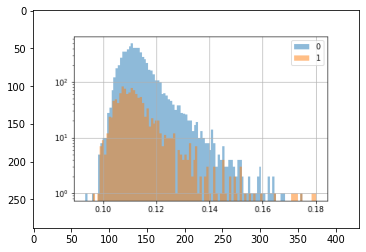

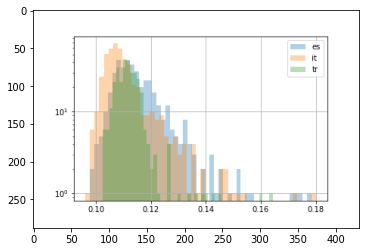

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('valid_hist.png')
_ = plt.imshow(img)
plt.show()
img = mpimg.imread('valid_toxic_hist.png')
_ = plt.imshow(img)